<h1 align="center">Projeto Final 2019</h1>

<h3 align="center">Gabriel Lima Novais</h3>

<p align="center"><b>Objetivo:</b> Neste projeto cada aluno deve eleger um corpus de documentos de tamanho médio (pelo menos milhares de documentos). Todas as tarefas a seguir serao realizadas sobre este corpus.</p>

<p align="center"><b>Corpus utililzado:</b> Base de artigos da Wikipedia (3.2GB). Para realizar o entendimento inicial de cada exercício (e até mesmo para a implementação), a estratégia utilizada por mim foi a de considerar um corpus de teste com número extramamente reduzido de artigos (10 artigos) e depois dessa etapa pegar a base de dados composta por 200.000 artigos.</p>

#### Importando pacotes:

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import whoosh
import nltk
import string
import enchant
import shutil
import gensim
import logging
#------------------------------------------------------------------------------------
from IPython.display import display, Markdown, Latex
from collections import defaultdict,Counter,OrderedDict
from math import log
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy.linalg import norm
from string import punctuation
#____________________________________________________________________________________
from gensim import corpora, models, similarities
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel,wrappers,FastText
#____________________________________________________________________________________
from nltk.corpus import machado, mac_morpho,stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer
#____________________________________________________________________________________
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
#____________________________________________________________________________________
from whoosh import sorting
from whoosh.index import create_in, open_dir
from whoosh.fields import *
from whoosh import qparser
from whoosh.qparser import QueryParser

#### Configurações iniciais:

In [2]:
#O corpus escolhido está em Inglês, então as devidas configurações são:
nltk.download('stopwords')
swu = stopwords.words('english')+ list(string.punctuation)
stopwords.words('english')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /home/novais/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Preparando o Corpus

In [24]:
def data(file,nr,sample):

    #Importando os dados da Wikipedia em formato csv:
    df = pd.read_table(file, sep=",", nrows=nr,header=None)

    #Tratando a base de dados:
    df.columns = ['id','content']
    df.id = df.id.apply(lambda x: int(x[10:]))

    #Retirando uma amostra pequena para realizar as questões da lista sem demorar muito...
    #OBS: Toda vez que rodar essa linha abixo o Corpus vai mudar e assim as respostas devem mudar!!!
    corpus =  df.sample(n=sample)
    corpus = corpus.reset_index().drop(['index'], axis=1)

    #Visualizando aas primeiras linhas do Corpus:
    return corpus

In [77]:
# corpus = data("corpusEx.csv",5000,5000)
# corpus.head()

<p>Guardando a base de Dados para consultas futuras:</p>

In [4]:
# corpus.to_csv('corpus_uso.csv')

In [5]:
corpus = pd.read_csv("corpus_uso.csv",index_col=0)
corpus.head()

,id,content
0,2092031,Military chaplain A military chaplain minist...
1,6729501,Scott Adsit Robert Scott Adsit (born Novembe...
2,24103697,Option Paralysis Option Paralysis is the fou...
3,34957804,Ford F-Series ninth generation The ninth gen...
4,2054313,"Leaellynasaura Leaellynasaura (meaning ""Leae..."


### (Questão 1) Indexação

<ul>
<li>Utilizando o Whoosh, indexar o seu corpus e implementar uma funçao que apresente para os top 10 documentos da resposta a uma consulta, trechos dos documentos contendo os termos da consulta.</li>
<li>Contruir uma funçao de busca que aceite consultas frasais e facetaçao dos resultados.</li>
</ul>

In [111]:
 
def whooshSearcher(sentence, corpus):
    #______________________________________________________________________________________________________   
    #Definindo variáveis auxiliares
    schema = Schema(cont=TEXT(phrase=True, stored=True))
    
    #Criando o indexidr:
    if os.path.exists('indexdir'):
        shutil.rmtree('/home/novais/Desktop/Mestrado/3_trim_2019/SRI/Trabalho Final/indexdir')
        os.mkdir('indexdir')
        ix = create_in("indexdir", schema)
        writer = ix.writer()
        for txt in corpus:
            writer.add_document(cont=txt)
        writer.commit()
    else:
        os.mkdir('indexdir')
        ix = create_in("indexdir", schema)
        writer = ix.writer()
        for txt in corpus:
            writer.add_document(cont=txt)
        writer.commit()
    #______________________________________________________________________________________________________
    
    aux=[]
    positions=[]


    query = QueryParser("cont", schema=ix.schema,group=qparser.OrGroup).parse(sentence)
    facets = sorting.Facets()
    facets.add_field("cont")
    facets.add_field("cont", allow_overlap=True)
    answer = ix.searcher().search(query,limit=10, groupedby=facets)
    for k in answer:
        positions.append(corpus[corpus.isin([k.values()[0]])].index[0])
    for hit in answer:
        aux.append(re.split("\.\.\.", hit.highlights("cont")))
    print("Resultados em ordem de similaridade:")
    print(" ")
    for j in range(min(10,len(aux))):
        print("Trechos do resultado "+str(j+1)+", linha "+str(positions[j])+" do Corpus")
        for i in range(len(aux[j])):
            display(Markdown("Trecho "+str(i)+":  [...] "+aux[j][i]+" [...]"))
        print(" ")


    return positions[:min(10,len(aux))]

<>:37: DeprecationWarning: invalid escape sequence \.
<>:37: DeprecationWarning: invalid escape sequence \.
<>:37: DeprecationWarning: invalid escape sequence \.
<ipython-input-111-db4e2200a575>:37: DeprecationWarning: invalid escape sequence \.
  aux.append(re.split("\.\.\.", hit.highlights("cont")))


In [112]:
whooshSearcher("Coke soda is good ",corpus.content)

Resultados em ordem de similaridade:
 
Trechos do resultado 1, linha 587 do Corpus


Trecho 0:  [...] the 1940s when local <b class="match term0">soda</b> fountain workers (<b class="match term0">soda</b> jerks) would upon request [...]

Trecho 1:  [...] <b class="match term1">Coke</b>, the company was hesitant to introduce anything [...]

Trecho 2:  [...] company said Vanilla <b class="match term1">Coke</b> and Diet Vanilla <b class="match term1">Coke</b> would possibly be made [...]

 
Trechos do resultado 2, linha 4187 do Corpus


Trecho 0:  [...] 250 million. <b class="match term1">Coke</b> also gained the rights [...]

Trecho 1:  [...] It was one of <b class="match term1">Coke</b>'s largest acquisitions [...]

Trecho 2:  [...] the maintenance of <b class="match term2">good</b> health. Fuze beverages [...]

 
Trechos do resultado 3, linha 4411 do Corpus


Trecho 0:  [...] Petroleum <b class="match term3">coke</b>  Petroleum <b class="match term3">coke</b> (often abbreviated [...]

Trecho 1:  [...] energy). Marketable <b class="match term3">coke</b>. Marketable <b class="match term3">coke</b> is <b class="match term3">coke</b> that is relatively [...]

Trecho 2:  [...] i.e., anode grade <b class="match term3">coke</b>). Needle <b class="match term3">coke</b>. Needle <b class="match term3">coke</b>, also called acicular [...]

 
Trechos do resultado 4, linha 1218 do Corpus


Trecho 0:  [...] He introduced the <b class="match term1">Coke</b> slogans "<b class="match term1">Coke</b> is it!", "You Can't Beat the [...]

Trecho 1:  [...] He launched Diet <b class="match term1">Coke</b>, as well as the ill-fated [...]

Trecho 2:  [...] New <b class="match term1">Coke</b>. In 1982 Goizueta approved [...]

 
Trechos do resultado 5, linha 1485 do Corpus


Trecho 0:  [...] Henkel's Bleich-<b class="match term4">Soda</b> <b class="match term4">Soda</b>, an affordably-priced [...]

Trecho 1:  [...] from water-glass and <b class="match term0">soda</b>, it was the result of [...]

Trecho 2:  [...] raw materials into <b class="match term0">soda</b>. On September 20, 1945 [...]

 
Trechos do resultado 6, linha 2695 do Corpus


Trecho 0:  [...] materials, caustic <b class="match term0">soda</b>, stones and decorative [...]

Trecho 1:  [...] in Iran are: <b class="match term1">Coke</b>. In 2015 Iran will produce [...]

Trecho 2:  [...] 1.7 million tons of <b class="match term1">Coke</b>. Zinc and lead. Iran has [...]

 
Trechos do resultado 7, linha 1654 do Corpus


Trecho 0:  [...] the characters in <b class="match term1">Coke</b>'s red-and-white colors [...]

Trecho 1:  [...] billboards with <b class="match term1">Coke</b> branding, <b class="match term1">Coke</b> "thought bubbles", <b class="match term1">Coke</b> bottle-shaped golf [...]

Trecho 2:  [...] designed around the <b class="match term1">Coke</b> theme. This game is rare [...]

 
Trechos do resultado 8, linha 3088 do Corpus


Trecho 0:  [...] cereals, and <b class="match term0">soda</b>. Publication details [...]

 
Trechos do resultado 9, linha 3944 do Corpus


Trecho 0:  [...] taking part in the <b class="match term1">Coke</b> Studio third season [...]

Trecho 1:  [...] with Arif Lohar at <b class="match term1">Coke</b> Studio in Karachi. It [...]

Trecho 2:  [...] May, the lineup for <b class="match term1">Coke</b> Studio confirmed that [...]

 
Trechos do resultado 10, linha 1037 do Corpus


Trecho 0:  [...] Parade" and "Club <b class="match term4">Soda</b>" respectively [...]

[587, 4187, 4411, 1218, 1485, 2695, 1654, 3088, 3944, 1037]

### (Questão 2) Modelagem de Assuntos
<ul>
    <li>Usando a biblioteca Gensim, treine um modelo LSI e LDA para o seu corpus propondo uma metodologia para otimizaçao do numero de assuntos</li>
    <li>Construa Uma matriz de similaridade entre os documentos do corpus a partir dos pesos</li>
</ul>

##### Algumas definições:
<b>TF-IDF : </b>In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

<b>LSA (LSI) : </b> Latent semantic analysis (LSA) is a technique in natural language processing, in particular distributional semantics, of analyzing relationships between a set of documents and the terms they contain by producing a set of concepts related to the documents and terms. LSA assumes that words that are close in meaning will occur in similar pieces of text (the distributional hypothesis). A matrix containing word counts per document (rows represent unique words and columns represent each document) is constructed from a large piece of text and a mathematical technique called singular value decomposition (SVD) is used to reduce the number of rows while preserving the similarity structure among columns. Documents are then compared by taking the cosine of the angle between the two vectors (or the dot product between the normalizations of the two vectors) formed by any two columns. Values close to 1 represent very similar documents while values close to 0 represent very dissimilar documents.

<b>Interpretação:</b> Para o TF-IDF, a função abaixo retorna o "peso" que cada palavra do dicionário construído a partir de cada texto do Corpus (palavras únicas) possui para aquele texto. Já para o LSI e LDA temos que é retornado para cada texto do Corpus um vetor que fornece o quanto cada tema está relacionado com aquele texto. Além disso podemos verificar também como cada tema é construído, isto é, quais palavras do dicionário construído anteriormente para elaborar o TF-IDF são as mais importantes para aquele tema. Abaixo veja as explicações ilistradas:  

In [28]:
def LS(txt,nthemes):
    
    try:
        os.remove("corpusWiki.mm")
        os.remove("corpusWiki.mm.index")
        os.remove("vocabulario.dict")
    except:
        print(" ")
    
    #________________________________________________________________________________________________________
    #Incializando vetores:
    txtClean = []
    c = Counter([])
    
    #Loop:
    for texto in txt:
        aux = [stemmer.stem(token.strip(punctuation).lower()) for token in WordPunctTokenizer().tokenize(texto) if token not in swu]
        c.update(aux)
        txtClean.append(aux)
    txtClean = [[token for token in t if c[token]>1] for t in txtClean]
    
    #________________________________________________________________________________________________________

    #Gerando dicionário:
    dicionario = corpora.Dictionary(txtClean)
    dicionario.save('vocabulario.dict')
    
    #________________________________________________________________________________________________________
    #Gerando as frequências:
    corpus = [dicionario.doc2bow(d) for d in txtClean]
    corpora.MmCorpus.serialize('corpusWiki.mm', corpus)
    
    #________________________________________________________________________________________________________
    #TF-IDF:
    mod_tfidf = models.TfidfModel(corpus)
    corpus_tfidf = mod_tfidf[corpus]
    #LSI:
    mod_lsi = models.LsiModel(corpus_tfidf, id2word=dicionario, num_topics=nthemes)
    corpus_lsi = mod_lsi[corpus_tfidf]
    #LDA:
    mod_lda = models.LdaModel(corpus_tfidf, id2word=dicionario, num_topics=nthemes)
    corpus_lda = mod_lda[corpus_tfidf]
    #________________________________________________________________________________________________________
    # Compute Perplexity
    perplexity = mod_lda.log_perplexity(corpus)
    #print('\nPerplexity: ', mod_lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=mod_lda, texts=txtClean, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    #print('\nCoherence Score: ', coherence_lda)
        
    return [mod_lsi,mod_lda,corpus_lsi,corpus_lda,corpus_tfidf,perplexity,coherence_lda,dicionario,txtClean]

<p>Exemplo de como está um texto do corpus:</p>

In [57]:
txt = corpus.content
txt[2]

' Option Paralysis  Option Paralysis is the fourth full-length studio album by American mathcore band The Dillinger Escape Plan, released on March 23, 2010. After having fulfilled their contract with Relapse Records, the band released the album through Party Smasher Inc., their own new imprint in collaboration with French record label Season of Mist. It marks The Dillinger Escape Plan\'s first release to feature Billy Rymer on drums, since Gil Sharone left the band in September 2008 due to the frequent touring schedule and to focus on his brother\'s band Stolen Babies. Background. Formation of Party Smasher Inc.. The Dillinger Escape Plan announced their departure from Relapse Records in 2009. They had become dissatisfied with the music industry and music media, and decided to create their own record label to release their fourth studio-album. Commenting on the dissolving "indie band culture", guitarist Ben Weinman stated, "back in the day there were record labels that you trusted, lov

<p>Agora vamos verificar de acordo com as métricas de Coeherence Score e Perplexity qual será o número ótimo de assuntos a serem abordados:</p>

In [ ]:
def coherence_values(txt, limit, start, step):
    coherence_values = []
    for num_topics in range(start, limit, step):
        modelo = LS(txt,num_topics)
        coherence_values.append(modelo[6])

    return coherence_values

def perplexity_values(txt, limit, start, step):
    perplexity_values = []
    for num_topics in range(start, limit, step):
        modelo = LS(txt,num_topics)
        perplexity_values.append(modelo[5])

    return perplexity_values

In [113]:
start = 2
step = 3
limit=15

In [37]:
coherence_values = coherence_values(txt,limit,start, step)
perplexity_values = perplexity_values(txt,limit,start, step)
perplexity_values_abs = [i/np.sum(perplexity_values) for i in perplexity_values]

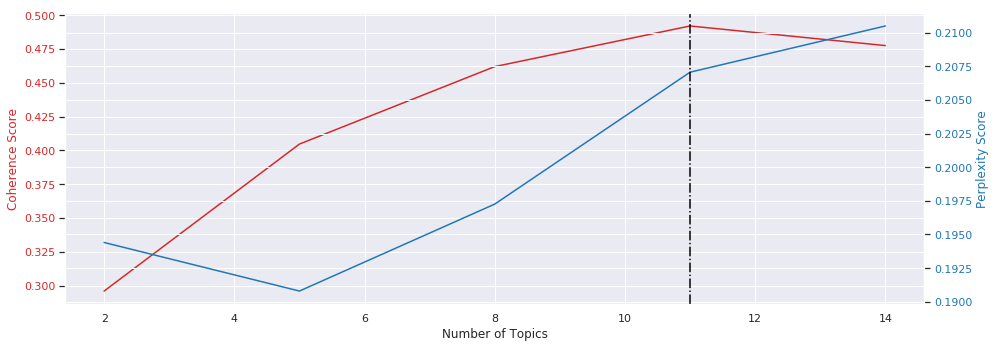

In [114]:
x = range(start, limit, step)
fig, ax1 = plt.subplots(figsize=(14,5))

color = 'tab:red'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence Score', color=color)
ax1.plot(x, coherence_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Perplexity Score', color=color) 
ax2.plot(x, perplexity_values_abs, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(x=11,color='#000000',linestyle='-.')
fig.tight_layout()
plt.show()

Veja que a quantidade de tópicos ótima nos parece ser a de valor 11, além disso conforme o tamanho do corpus vai aumentando temos que o limite máximo de assuntos intutitivamente deve ser o tamanho do próprio corpus. Então, dado o tamanho do corpus encontramos o que possui o maior "CS". Outro ponto importante seria analisar o "perplexity", cujo valor quanto menor melhor (no caso do gráfico seria o maior, devido a normalização e o valor absoluto).

In [67]:
number_of_topics = 11

O resultado do TF-IDF para este texto é tal que as palavras, cujos indices estão em primeiro lugar nas tuplas abaixo, possuem um nível de importância determinado pelo segundo número da tupla:

In [66]:
model = LS(txt,number_of_topics)

In [78]:
model[4][2]

[(0, 0.011716873040299978),
 (1, 0.007760957685400791),
 (2, 0.031082126340848563),
 (3, 0.013501361750502776),
 (34, 0.00862979892717694),
 (36, 0.01550923071384607),
 (40, 0.009514520540940213),
 (41, 0.014107153747652961),
 (46, 0.010351879468714806),
 (47, 0.026444166857044475),
 (52, 0.00481923395049694),
 (57, 0.011921586683009498),
 (64, 0.010461904069766239),
 (65, 0.02257190025981181),
 (78, 0.009395519697465039),
 (92, 0.0022463271718933275),
 (106, 0.0098114672741643),
 (140, 0.014206425128753296),
 (150, 0.02733208532605752),
 (162, 0.008814823876115895),
 (163, 0.00949890333804212),
 (180, 0.016725983845536647),
 (181, 0.06809475421107494),
 (202, 0.006763631840976296),
 (209, 0.02138857743223394),
 (222, 0.02033200943120873),
 (223, 0.010591116565097083),
 (244, 0.022474755428989114),
 (281, 0.03985896126163612),
 (282, 0.0178492852140307),
 (291, 0.010788716595856562),
 (298, 0.03236614978756968),
 (300, 0.01395599177704068),
 (306, 0.021495424711588718),
 (310, 0.036173

Agora, os tópicos selecionados pelo modelo de LSI e LDA e determinados (cada um) por uma quantidade de 4 palavras estão descritos abaixo pelo seu índice especificado no primeiro termo da tupla:

In [79]:
#LSI:
model[0].print_topics(num_topics=number_of_topics, num_words=4)

[(0, '0.181*"album" + 0.116*"film" + 0.105*"song" + 0.093*"music"'),
 (1, '0.599*"album" + 0.263*"song" + 0.243*"band" + 0.185*"releas"'),
 (2, '-0.319*"game" + -0.215*"season" + -0.204*"film" + -0.195*"team"'),
 (3, '0.444*"film" + -0.298*"game" + 0.200*"she" + -0.168*"player"'),
 (4, '0.226*"film" + -0.157*"elect" + -0.123*"senat" + -0.118*"album"'),
 (5, '0.151*"game" + 0.143*"court" + 0.141*"law" + 0.119*"senat"'),
 (6, '0.167*"speci" + -0.150*"engin" + -0.137*"court" + -0.123*"f"'),
 (7, '0.305*"game" + -0.227*"student" + -0.217*"univers" + -0.198*"school"'),
 (8, '-0.200*"court" + -0.199*"speci" + 0.177*"armi" + 0.152*"game"'),
 (9, '-0.393*"game" + 0.171*"f" + 0.131*"ford" + 0.120*"race"'),
 (10, '0.337*"film" + -0.218*"game" + -0.208*"ford" + -0.200*"f"')]

In [80]:
#LDA:
model[1].print_topics(num_topics=number_of_topics, num_words=4)

[(0, '0.001*"album" + 0.001*"song" + 0.001*"she" + 0.001*"music"'),
 (1, '0.001*"f" + 0.001*"truck" + 0.001*"speci" + 0.001*"ford"'),
 (2, '0.001*"whale" + 0.001*"orbit" + 0.000*"airport" + 0.000*"ventricular"'),
 (3, '0.001*"imam" + 0.000*"massey" + 0.000*"toyota" + 0.000*"cowboy"'),
 (4,
  '0.001*"passport" + 0.001*"game" + 0.001*"leagu" + 0.000*"semiconductor"'),
 (5, '0.001*"game" + 0.001*"film" + 0.001*"team" + 0.001*"system"'),
 (6, '0.001*"court" + 0.001*"ibn" + 0.001*"al" + 0.001*"elect"'),
 (7, '0.000*"gannet" + 0.000*"afc" + 0.000*"lorentz" + 0.000*"hypothalamus"'),
 (8, '0.001*"equat" + 0.000*"hockey" + 0.000*"commut" + 0.000*"chees"'),
 (9, '0.002*"album" + 0.002*"film" + 0.002*"song" + 0.001*"band"'),
 (10, '0.000*"colombia" + 0.000*"tornado" + 0.000*"kazakh" + 0.000*"vowel"')]

Então, como já sabemos como estão descritos cada um dos tópicos acima, podemos interpretar quem eles são. Depois de buscar a interpretação neles, vamos verificar se de fato os assuntos listados acima descrevem bem o assunto do primeiro texto do nosso corpus:

In [81]:
#LSI:
model[2][2]

[(0, 0.24000639006394756),
 (1, 0.3246597458017028),
 (2, 0.07264499483765942),
 (3, -0.06987538064684076),
 (4, -0.0314033737785865),
 (5, 0.01404854365412769),
 (6, -0.021978052316929165),
 (7, 0.00041876917528109643),
 (8, 0.0009424605068392764),
 (9, -0.0011998869792385404),
 (10, 0.011363519049202382)]

In [83]:
#LDA:
model[3][2]

[(9, 0.92140585)]

E verificando cada um deles vemos que de fato o tema está bem similar ao que é descrito no texto procurado. 

In [85]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model[1], model[3],model[7])
vis

/home/novais/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.092705  0.046526       1        1  29.891575
1      0.017632  0.003260       2        1  24.230846
5     -0.104477 -0.040147       3        1   6.538248
6     -0.013635 -0.012711       4        1   4.917593
8      0.002686 -0.002654       5        1   4.917486
2      0.029337 -0.008670       6        1   4.917455
4      0.010036  0.001861       7        1   4.917421
0      0.011018  0.013135       8        1   4.917394
7      0.047082  0.001308       9        1   4.917336
3      0.040668 -0.002081      10        1   4.917331
10     0.052360  0.000173      11        1   4.917317, topic_info=      Category      Freq       Term     Total  loglift  logprob
term                                                           
1331   Default  4.000000      album  4.000000  30.0000  30.0000
1202   Default  1.000000       game  1.000000  29.0000  29.0000
2642   Default  3.000000       film  3.000000  28.0000  28.0000
1478   Default  2.000000       song  2.000000  27.0000  27.0000
296    Default  1.000000      court  1.000000  26.0000  26.0000
1436   Default  2.000000      music  2.000000  25.0000  25.0000
3375   Default  2.000000        she  2.000000  24.0000  24.0000
1206   Default  2.000000         he  2.000000  23.0000  23.0000
1301   Default  1.000000       team  1.000000  22.0000  22.0000
2035   Default  0.000000      elect  0.000000  21.0000  21.0000
233    Default  1.000000     church  1.000000  20.0000  20.0000
381    Default  1.000000      engin  1.000000  19.0000  19.0000
1145   Default  2.000000       band  2.000000  18.0000  18.0000
982    Default  1.000000     system  1.000000  17.0000  17.0000
1290   Default  1.000000     season  1.000000  16.0000  16.0000
4674   Default  0.000000        ibn  0.000000  15.0000  15.0000
1712   Default  1.000000     player  1.000000  14.0000  14.0000
1778   Default  1.000000      truck  1.000000  13.0000  13.0000
957    Default  1.000000      state  1.000000  12.0000  12.0000
2130   Default  0.000000      leagu  0.000000  11.0000  11.0000
1907   Default  0.000000         al  0.000000  10.0000  10.0000
14870  Default  0.000000      whale  0.000000   9.0000   9.0000
485    Default  0.000000     govern  0.000000   8.0000   8.0000
1068   Default  1.000000        war  1.000000   7.0000   7.0000
593    Default  0.000000        law  0.000000   6.0000   6.0000
1047   Default  1.000000        use  1.000000   5.0000   5.0000
1036   Default  1.000000    univers  1.000000   4.0000   4.0000
1267   Default  1.000000       play  1.000000   3.0000   3.0000
725    Default  0.000000       oper  0.000000   2.0000   2.0000
1585   Default  1.000000    compani  1.000000   1.0000   1.0000
...        ...       ...        ...       ...      ...      ...
20549  Topic11  0.049646         vj  0.100811   2.3041  -8.4936
19084  Topic11  0.053888     glucos  0.112188   2.2791  -8.4117
15782  Topic11  0.056512     conson  0.123094   2.2339  -8.3641
11309  Topic11  0.054355      hasan  0.120586   2.2156  -8.4030
27899  Topic11  0.037668    bridger  0.085295   2.1951  -8.7698
7147   Topic11  0.057349     kernel  0.133281   2.1691  -8.3494
7199   Topic11  0.044366       verb  0.106320   2.1384  -8.6061
12165  Topic11  0.048023  barcelona  0.117666   2.1162  -8.5269
8169   Topic11  0.120779   colombia  0.300642   2.1004  -7.6046
24696  Topic11  0.031229    sussman  0.078913   2.0854  -8.9572
21250  Topic11  0.033171   división  0.083993   2.0833  -8.8969
11837  Topic11  0.034656       soup  0.090266   2.0551  -8.8531
27571  Topic11  0.028970        4ad  0.076625   2.0398  -9.0323
34964  Topic11  0.028763     schere  0.076398   2.0355  -9.0395
32761  Topic11  0.028094     chaser  0.075786   2.0201  -9.0630
41345  Topic11  0.027146    mersenn  0.074711   2.0000  -9.0973
30686  Topic11  0.026298     citadi  0.073859   1.9797  -9.1291
26640  Topic11  0.026881     kisser  0.077973   1.9475 

Finalmente fazendo a matriz de similaridade de acordo com o pacote Gensim, obtemos que:

In [91]:
fonte = similarities.MatrixSimilarity(model[3])
fonte = list(fonte)
head = list(corpus.id)
fonte.insert(0,np.array(head))


ms = pd.DataFrame(fonte[1:],index=np.array(head),columns=np.array(head))
sample = ms.iloc[:10,:10]
sample

,2092031,6729501,24103697,34957804,2054313,233750,659663,642769,2079029,19944098
2092031,1.000000,0.369748,0.369684,0.888804,0.803369,0.922942,0.637631,0.952383,0.833171,0.515231
6729501,0.369748,1.000000,0.909192,0.264499,0.697450,0.154997,0.052538,0.440725,0.587863,0.908167
24103697,0.369684,0.909192,1.000000,0.263514,0.727357,0.146731,0.016912,0.465534,0.608837,0.985443
34957804,0.888804,0.264499,0.263514,1.000000,0.722444,0.912957,0.626651,0.909915,0.764596,0.410812
2054313,0.803369,0.697450,0.727357,0.722444,1.000000,0.683505,0.449001,0.854731,0.860190,0.821581
233750,0.922942,0.154997,0.146731,0.912957,0.683505,1.000000,0.684890,0.938199,0.749897,0.306848
659663,0.637631,0.052538,0.016912,0.626651,0.449001,0.684890,1.000000,0.620642,0.500411,0.143208
642769,0.952383,0.440725,0.465534,0.909915,0.854731,0.938199,0.620642,1.000000,0.875892,0.603276
2079029,0.833171,0.587863,0.608837,0.764596,0.860190,0.749897,0.500411,0.875892,1.000000,0.718853
19944098,0.515231,0.908167,0.985443,0.410812,0.821581,0.306848,0.143208,0.603276,0.718853,1.000000


<p>Podemos verificar a matriz de similaridade no seguinte heatmap:</p>

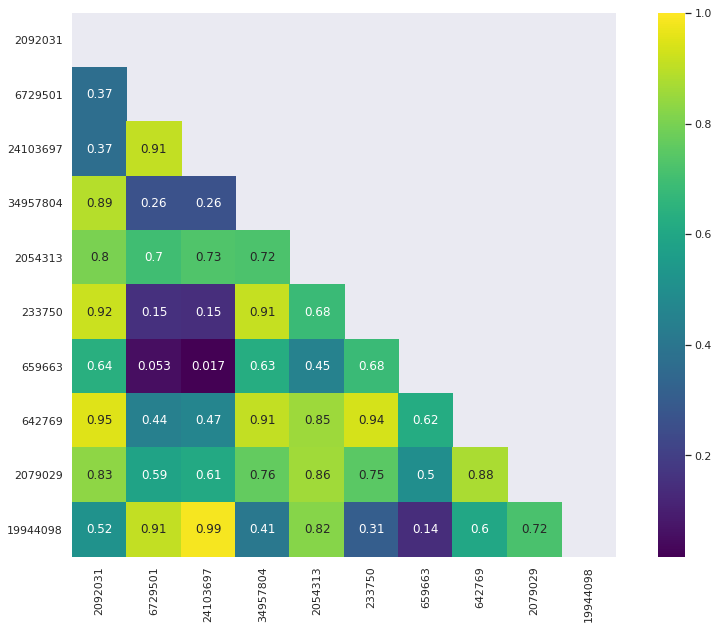

In [104]:
plt.figure(figsize=(15,10))
mask = np.zeros_like(sample)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(sample, mask=mask, square=True,annot = True,cmap="viridis")

In [109]:
texto_24103697 = corpus[corpus.id == 24103697]["content"].values[0]
texto_24103697

' Option Paralysis  Option Paralysis is the fourth full-length studio album by American mathcore band The Dillinger Escape Plan, released on March 23, 2010. After having fulfilled their contract with Relapse Records, the band released the album through Party Smasher Inc., their own new imprint in collaboration with French record label Season of Mist. It marks The Dillinger Escape Plan\'s first release to feature Billy Rymer on drums, since Gil Sharone left the band in September 2008 due to the frequent touring schedule and to focus on his brother\'s band Stolen Babies. Background. Formation of Party Smasher Inc.. The Dillinger Escape Plan announced their departure from Relapse Records in 2009. They had become dissatisfied with the music industry and music media, and decided to create their own record label to release their fourth studio-album. Commenting on the dissolving "indie band culture", guitarist Ben Weinman stated, "back in the day there were record labels that you trusted, lov

In [110]:
texto_19944098 = corpus[corpus.id == 19944098]["content"].values[0]
texto_19944098

' Fruits of Passion  Fruits of Passion is a 1981 French-Japanese co-production directed by Shūji Terayama and starring Klaus Kinski which was released in France as "Les fruits de la passion" and in Japan as . The film is loosely based on the novel "Retour à Roissy" by Pauline Réage, written as a sequel to the "Story of O". Plot. The lead characters of the "Story of O" and "Retour à Roissy" novels, Sir Stephen and O, are placed in southern China where Sir Stephen owns a casino. Sir Stephen places O in a Chinese brothel for "training" and O is then subjected to a variety of humiliating experiences to prove her unconditional obedience. A sub-plot concerns a coolie rebellion due to the resentment towards Europeans by the local population and a young man desperate to afford O\'s favors at the brothel. Release. The film was released in France on June 3, 1981 as "Les fruits de la passion" and as "Shanghai Ijin Shōkan - China Doll" in Japan with censoring of the pubic areas in November 1981. T

### (Questão 3) Word2vec

<ul>
    <li>Ainda usando a biblioteca Gensim, construa uma representaçao vetorial semântica (Word2vec) do seu corpus de escolha. Podem seguir este tutorial <a href="https://rare-technologies.com/word2vec-tutorial/">https://rare-technologies.com/word2vec-tutorial/</a></li>
    <li>Construa uma representaçao similar usando <a href="https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText">FastText</a>. Veja este <a href="https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/FastText_Tutorial.ipynb">Tutorial</a></li>
</ul>

In [6]:
corpus.head()

,id,content
0,2092031,Military chaplain A military chaplain minist...
1,6729501,Scott Adsit Robert Scott Adsit (born Novembe...
2,24103697,Option Paralysis Option Paralysis is the fou...
3,34957804,Ford F-Series ninth generation The ninth gen...
4,2054313,"Leaellynasaura Leaellynasaura (meaning ""Leae..."


In [7]:
def W2V(txt):
    
    try:
        os.remove("corpusWikiW2V.mm")
        os.remove("corpusWikiW2V.mm.index")
        os.remove("vocabularioW2V.dict")
    except:
        print(" ")
    
    #logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    #________________________________________________________________________________________________________
    #Incializando vetores:
    txtClean = []
    c = Counter([])
    
    #Loop:
    for texto in txt:
        aux = [stemmer.stem(token.strip(punctuation).lower()) for token in WordPunctTokenizer().tokenize(texto) if token not in swu]
        c.update(aux)
        txtClean.append(aux)
    txtClean = [[token for token in t if c[token]>1] for t in txtClean]
    
    #________________________________________________________________________________________________________

    #Gerando dicionário:
    dicionario = corpora.Dictionary(txtClean)
    dicionario.save('vocabularioW2V.dict')
    
    #________________________________________________________________________________________________________
    #Gerando as frequências:
    corpus = [dicionario.doc2bow(d) for d in txtClean]
    corpora.MmCorpus.serialize('corpusWikiW2V.mm', corpus)
    
    #________________________________________________________________________________________________________
    #TF-IDF:
    mod_tfidf = models.TfidfModel(corpus)
    corpus_tfidf = mod_tfidf[corpus]
    #W2V:
    mod_w2v = models.Word2Vec(txtClean, min_count=1)
#     corpus_w2v = mod_w2v[txtClean]
          
#     return [mod_w2v,corpus_w2v,dicionario]
    return mod_w2v

In [34]:
vetor = W2V(corpus.content)

In [42]:
print("Comparação entre duas palavras do Vocabulário: 'band' e 'film'. Similaridade: "+str(np.round(vetor.wv.n_similarity("band", "film")*100,2))+"%")
print("Comparação entre dois vetores do Vocabulário: ['band','star'] e ['film','star']. Similaridade: "+str(np.round(vetor.wv.n_similarity(["band","star"], ["film","star"])*100,2))+"%")

Comparação entre duas palavras do Vocabulário: 'band' e 'film'. Similaridade: 81.97%
Comparação entre dois vetores do Vocabulário: ['band','star'] e ['film','star']. Similaridade: 66.67%


<p><b>Explicação</b>: Através do Gensim conseguimos treinar um modelo de Word2Vec para o corpus de escolha, de maneira que agora podemos comparar dois vetores de palavras e retornar um valor de similaridade entre eles. Entretanto não conseguimos fazer isso com palavras que estejam fora do vocabulário criado. Para que seja possível fazer isso precisamos utilizar o FastText, cujos links encontram-se no enunciado. Vamos então implementar este modelo.</p>

In [16]:
ftvetor = FastText(corpus.content, min_count=1)

</p>Comparando agora os valores de similaridade com as palavras anteriores:</p>

In [36]:
print("Comparação entre duas palavras do Vocabulário: 'band' e 'film'. Similaridade: "+str(np.round(ftvetor.wv.n_similarity("band", "film")*100,2))+"%")

Comparação entre duas palavras do Vocabulário: 'band' e 'film'. Similaridade: 77.88%


In [41]:
print("Comparação entre dois vetores do Vocabulário: ['band','star'] e ['film','star']. Similaridade: "+str(np.round(ftvetor.wv.n_similarity(["band","star"], ["film","star"])*100,2))+"%")

Comparação entre dois vetores do Vocabulário: ['band','star'] e ['film','star']. Similaridade: 33.85%


<p>Pegando uma palavra ("movie") que não está no vocabulário para comparar a similaridade dela com outras que estão lá:</p>

In [43]:
print("Comparação entre duas palavras do Vocabulário: 'movie' e 'film'. Similaridade: "+str(np.round(ftvetor.wv.n_similarity("movie", "film")*100,2))+"%")

Comparação entre duas palavras do Vocabulário: 'movie' e 'film'. Similaridade: 90.68%


In [44]:
print("Comparação entre dois vetores do Vocabulário: ['movie','star'] e ['film','star']. Similaridade: "+str(np.round(ftvetor.wv.n_similarity(["movie","star"], ["film","star"])*100,2))+"%")

Comparação entre dois vetores do Vocabulário: ['movie','star'] e ['film','star']. Similaridade: 56.68%


<p>Veja que os resultados obtidos com o FastText são parecidos com o Word2Vec, e percebe-se que em ambos os modelos a similaridade cai muito quando as mesmas palavras ficam inseridos em dois vetores. Porém, pelo fato da aplicação do Word2Vec ser restrito ao uso das palavras do Vocabulário construído, o segundo modelo utilizando o FastText parece ser melhor para usos mais genéricos. </p>

<b>FIM</b>